In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

from CIFAR100_helper import *
from model import *
from common import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

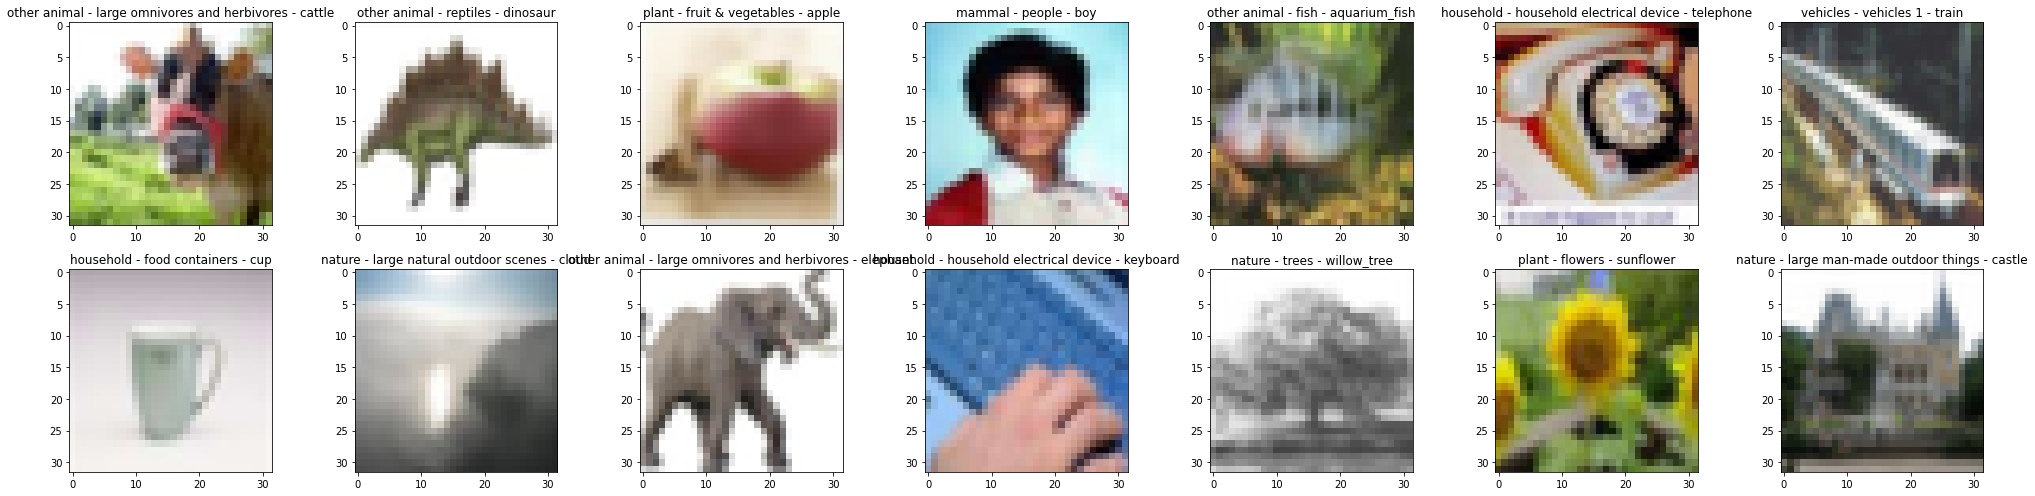

In [3]:
X, Y_ultra, Y_super, Y_sub = get_cifar100()
plot_sample_images((X, Y_ultra, Y_super, Y_sub), v_get_labels)

In [4]:
def create_classifier(img_input, n_classes, fc_dropout=0.3, activation='relu', class_type = 'default', nodes = 64):
    x = vgg13(img_input, conv_dropout=0.3, class_type=class_type)
    x = Dropout(0.5, name=f'{class_type}_dropout')(x)
    
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(x)
#     x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2', enable_dropout=False)(x)
    
    # Classification block    
    x = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    
    return x

In [5]:
def create_model(plot=False):
    n_ultraclasses = 7
    n_superclasses = 20
    n_subclasses = 100
    input_shape = x_train[0].shape

    img_input = Input(shape=input_shape, name='input')

    ultra_class_branch = create_classifier(img_input, n_ultraclasses ,class_type = 'ultra')
    super_class_branch = create_classifier(img_input, n_superclasses ,class_type = 'super')
    sub_class_branch = create_classifier(img_input, n_subclasses ,class_type = 'sub')
    model = keras.Model(inputs=img_input,
                 outputs = [ultra_class_branch, super_class_branch, sub_class_branch],
                 name="cifar100")
    if plot:
        fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=75)
        display(fig)
        
    init_lr = 5e-4
    lr_decay = 1e-6

    opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

    model.compile(
        optimizer=opt,
        loss={
            'ultra_output':'categorical_crossentropy',
            'super_output':'categorical_crossentropy',
            'sub_output':'categorical_crossentropy'
        },
        metrics={
            'ultra_output':'accuracy',
            'super_output':'accuracy',
            'sub_output':'accuracy'
        },
    )
    
    return model

Training on fold 1/5...


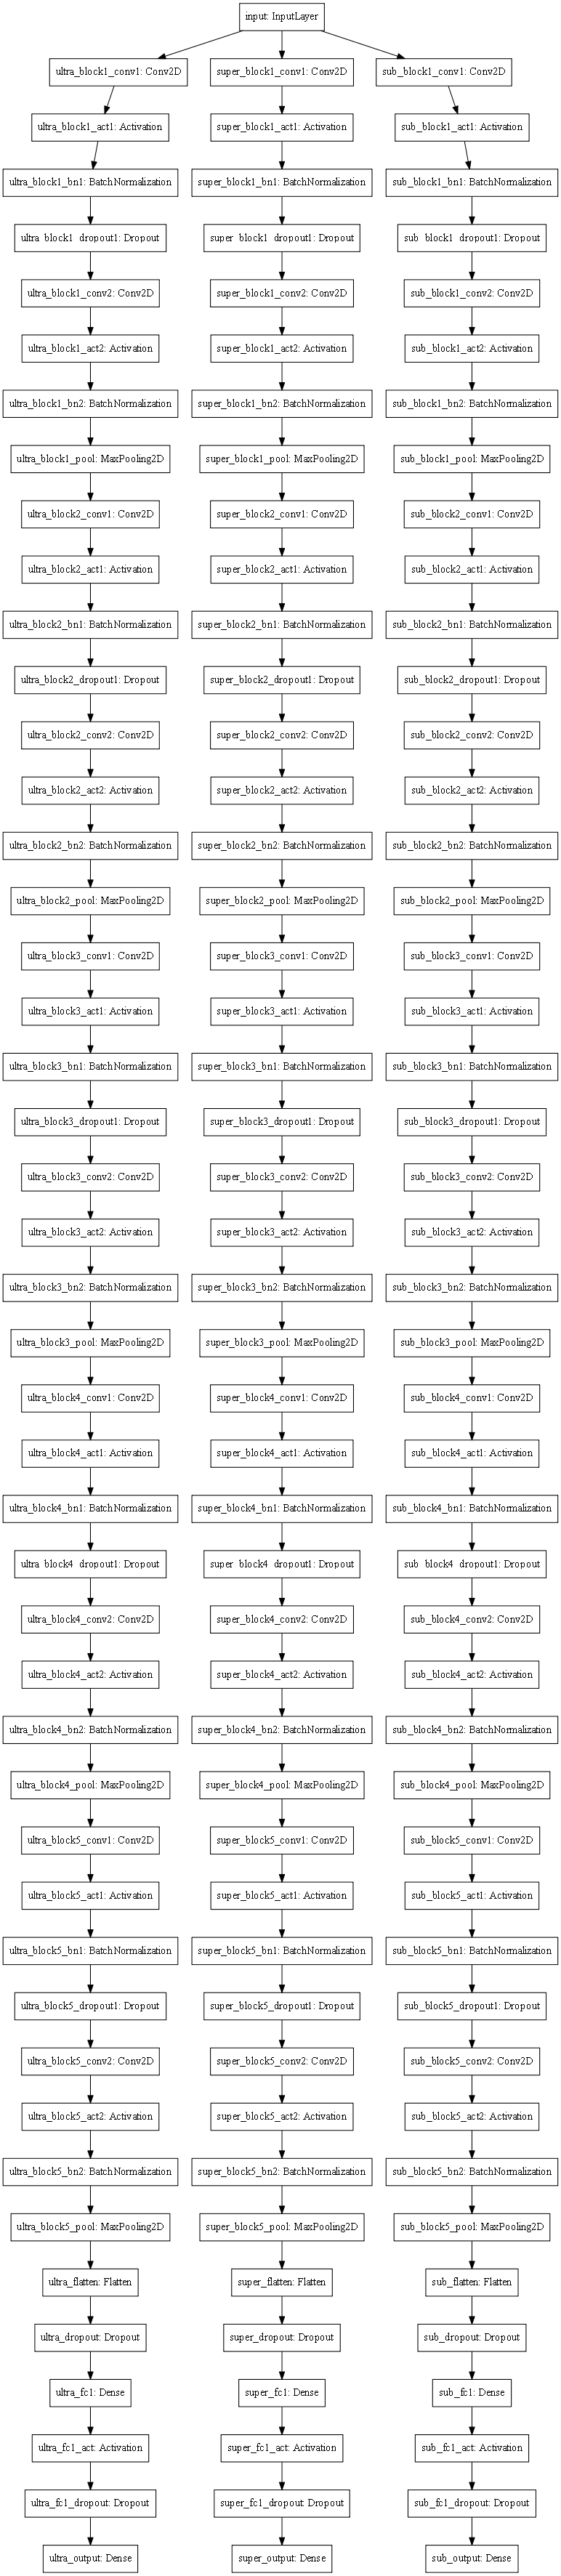

Epoch 1/60
150/150 [==============================] - 34s 187ms/step - loss: 10.6883 - ultra_output_loss: 2.2818 - super_output_loss: 3.3516 - sub_output_loss: 5.0549 - ultra_output_accuracy: 0.2851 - super_output_accuracy: 0.1159 - sub_output_accuracy: 0.0229 - val_loss: 10.1384 - val_ultra_output_loss: 2.1495 - val_super_output_loss: 3.1855 - val_sub_output_loss: 4.8034 - val_ultra_output_accuracy: 0.1548 - val_super_output_accuracy: 0.0489 - val_sub_output_accuracy: 0.0098
Epoch 2/60
150/150 [==============================] - 25s 170ms/step - loss: 8.0606 - ultra_output_loss: 1.5009 - super_output_loss: 2.4837 - sub_output_loss: 4.0759 - ultra_output_accuracy: 0.4157 - super_output_accuracy: 0.2271 - sub_output_accuracy: 0.0710 - val_loss: 12.5357 - val_ultra_output_loss: 3.5103 - val_super_output_loss: 3.5444 - val_sub_output_loss: 5.4811 - val_ultra_output_accuracy: 0.1507 - val_super_output_accuracy: 0.0529 - val_sub_output_accuracy: 0.0105
Epoch 3/60
150/150 [===================

In [6]:
stats =[]
n_splits = 5
epochs = 60
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, np.argmax(Y_sub, axis=1))):
    print (f"Training on fold {index + 1}/{n_splits}...")
    x_train, y_ultra_train, y_super_train, y_sub_train = X[train_indices], Y_ultra[train_indices], Y_super[train_indices], Y_sub[train_indices]
    x_test, y_ultra_test, y_super_test, y_sub_test = X[val_indices], Y_ultra[val_indices], Y_super[val_indices], Y_sub[val_indices]
    model = None
    model = create_model(True if index == 0 else False)
    stats.append(train_and_predict(model, epochs, (x_train, y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test)))
    reset_keras(model)

In [7]:
for i, stat in enumerate(stats):
    print(f"Fold {i + 1}: {stat}")

print("\n\nAverage [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:")
for i in range(len(stats[0])):
    print(sum([x[i] for x in stats]) / len(stats))

Fold 1: (0.33666666666666667, 0.47608333333333336, 0.29847222222222225)
Fold 2: (0.33816666666666667, 0.46358333333333335, 0.2996944444444445)
Fold 3: (0.33758333333333335, 0.44725, 0.28105555555555556)
Fold 4: (0.3398333333333333, 0.4595, 0.3010277777777777)
Fold 5: (0.33075, 0.46908333333333335, 0.2983055555555556)


Average [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:
0.33660000000000007
0.4631
0.29571111111111115
